In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def image_denoising(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0, 0)
    
    return blurred

In [3]:
def edge_detection(img, sigma = 0.33):
    
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(img, lower, upper)

    return edged

In [4]:
def image_masking(img, vertices):
    
    mask = np.zeros_like(img)
    
    cv2.fillPoly(mask, vertices, 255)
    
    masked = cv2.bitwise_and(img, mask)
    
    return masked

In [5]:
def hough_lines_detection(img):
    
    return cv2.HoughLinesP(img, 1, np.pi/180, 25, minLineLength=10, maxLineGap=50)

In [6]:
def left_and_right_lines_separation(yy, lines):

    def make_coordinates(y, line_parameters):
        slope, intercept = line_parameters
        y1 = y
        y2 = np.int64(y1*73/100)
        x1 = np.int64((y1 - intercept)/slope)
        x2 = np.int64((y2 - intercept)/slope)
        return np.array([x1,y1,x2,y2])
    
    global left_line 
    global right_line 
    left_fit = []
    right_fit = []
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            if slope < 0:
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))
        left_fit_avg = np.average(left_fit, axis=0)
        right_fit_avg = np.average(right_fit, axis=0)
        
        if left_fit !=[]:
            left_line = make_coordinates(yy, left_fit_avg)
        
        if right_fit != []:
            right_line = make_coordinates(yy, right_fit_avg)
        
        return np.array([left_line, right_line])

In [7]:
def complete_line_drawing(img,lines):
    global _x1
    global _y1
    global _x2
    global _y2
    line_img = np.zeros_like(img)
    # print(lines)
    if lines is not None:
        for line in lines:
            if line.size>0:
                x1, y1, x2, y2 = line.reshape(4)
                if x1 < 0 or x1 > width:
                    x1 = _x1
                if y1 < 0 or y1 > height:
                    y1 = _y1
                if x2 < 0 or x2 > width:
                    x2 = _x2
                if y2 < 0 or y2 > height:
                    y2 = _y2
                _x1, _y1, _x2, _y2 = x1, y1, x2, y2
                cv2.line(line_img,(x1, y1),(x2,y2),(255,0,0),10)
    return line_img

In [8]:
def turn_prediction(img):
    global H_matrix
    new_img = cv2.warpPerspective(img, H_matrix, (400, 600))
    
    

    # Use histogram to get pixels with max Y axis value
    histogram = np.sum(new_img, axis=0)

    midpoint = np.int(histogram.shape[0] / 2)

    # Compute the left and right max pixels
    leftx_ = np.argmax(histogram[:midpoint])
    rightx_ = np.argmax(histogram[midpoint:]) + midpoint
    #print(leftx_base)

    left_lane_pos = leftx_
    right_lane_pos = rightx_
    image_center = int(new_img.shape[1] / 2)

    lane_center = left_lane_pos + (right_lane_pos - left_lane_pos) / 2

    if (lane_center - image_center < -15):
        return ("Turning left")
    elif (lane_center - image_center < 15):
        return ("straight")
    else:
        return ("Turning right")

In [9]:
def demo_with_image():    
    fig, ax = plt.subplots(3, 3,figsize=(18, 24))
    
    img=mpimg.imread('meta/original.png', 1)    
    ax[0,0].imshow(img)
    ax[0,0].set_title('Original Image')
    ax[0,0].axis('off')  # clear x-axis and y-axis
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mpimg.imsave("meta/gray.png",gray_img, cmap='gray')
    ax[0,1].imshow(gray_img, cmap='gray')
    ax[0,1].set_title('Gray')
    ax[0,1].axis('off')  # clear x-axis and y-axis
    
    denoised_img = image_denoising(img)
    mpimg.imsave("meta/denoised.png",denoised_img, cmap='gray')
    ax[0,2].imshow(denoised_img, cmap='gray')
    ax[0,2].set_title('Image Denoising')
    ax[0,2].axis('off')  # clear x-axis and y-axis

    edge = edge_detection(denoised_img)
    mpimg.imsave("meta/edged.png",edge, cmap='gray')
    ax[1,0].imshow(edge, cmap='gray')
    ax[1,0].set_title('Edge Detection')
    ax[1,0].axis('off')  # clear x-axis and y-axis
    
    masked_img = image_masking(edge, vertice)
    mpimg.imsave("meta/masked.png",masked_img, cmap='gray')
    ax[1,1].imshow(masked_img, cmap='gray')
    ax[1,1].set_title('Masking Image')
    ax[1,1].axis('off')  # clear x-axis and y-axis
    
    
    lines = hough_lines_detection(masked_img)
    left_and_right_lines = left_and_right_lines_separation(img.shape[0], lines)
    line_image = complete_line_drawing(img,  left_and_right_lines)
    mpimg.imsave("meta/draw_lines.png",line_image)
    ax[1,2].imshow(line_image)
    ax[1,2].set_title('Lines')
    ax[1,2].axis('off')  # clear x-axis and y-axis
    
    
    result = cv2.addWeighted(img, 0.8, line_image, 1, 1)
    mpimg.imsave("meta/lane_lines.png",result)
    ax[2,0].imshow(result)
    ax[2,0].set_title('Lane Detection')
    ax[2,0].axis('off')  # clear x-axis and y-axis
    
    prediction = turn_prediction(masked_img)
    cv2.putText(result, "Prediction:" + prediction, (50*width//1024, 50*width//1000), cv2.FONT_HERSHEY_SIMPLEX, 1.5*width/1000, (0, 0, 255), 2, cv2.LINE_AA)
    
    
    global H_matrix
    new_img = cv2.warpPerspective(masked_img, H_matrix, (400, 600))
    mpimg.imsave("meta/Homograph.png",new_img, cmap='gray')
    ax[2,1].imshow(new_img, cmap='gray')
    ax[2,1].set_title('Homograph')
    ax[2,1].axis('off')  # clear x-axis and y-axis
    

    
    mpimg.imsave("meta/prediction.png",result)
    ax[2,2].imshow(result)
    ax[2,2].set_title('Prediction')
    ax[2,2].axis('off')  # clear x-axis and y-axis
    
    plt.show()

In [10]:
filename = "input_1280-720.mp4"



_x1, _y1, _x2, _y2 = 0, 0, 0, 0

left_line =np.array([])
right_line =np.array([])

cap = cv2.VideoCapture(filename)
width = int(cap.get(3))
height = int(cap.get(4))
size = (width, height)
vertice = np.array([[
    ((width*2)//10, height), 
    ((width*9)//10, height),
    ((width*4)//7, (7*height)//10), 
    ((width*75)//140, (9*height)//10), 
    ((width*5)//10, (7*height)//10)]])

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("output_"+str(width)+"-"+str(height)+".mp4", fourcc, 30, size) 

# Source points for homography
src = np.array([
    ((width*2)/10, height), 
    ((width*9)/10, height),
    ((width*4)/7, (7*height)/10),  
    ((width*5)/10, (7*height)/10)], dtype="float32")

# Destination points for homography
shift = 80
dst = np.array([[0+shift, 0], [250+shift, 0], [340+shift, 500], [40+shift, 400]], dtype="float32")

#Homography
H_matrix = cv2.getPerspectiveTransform(src, dst)

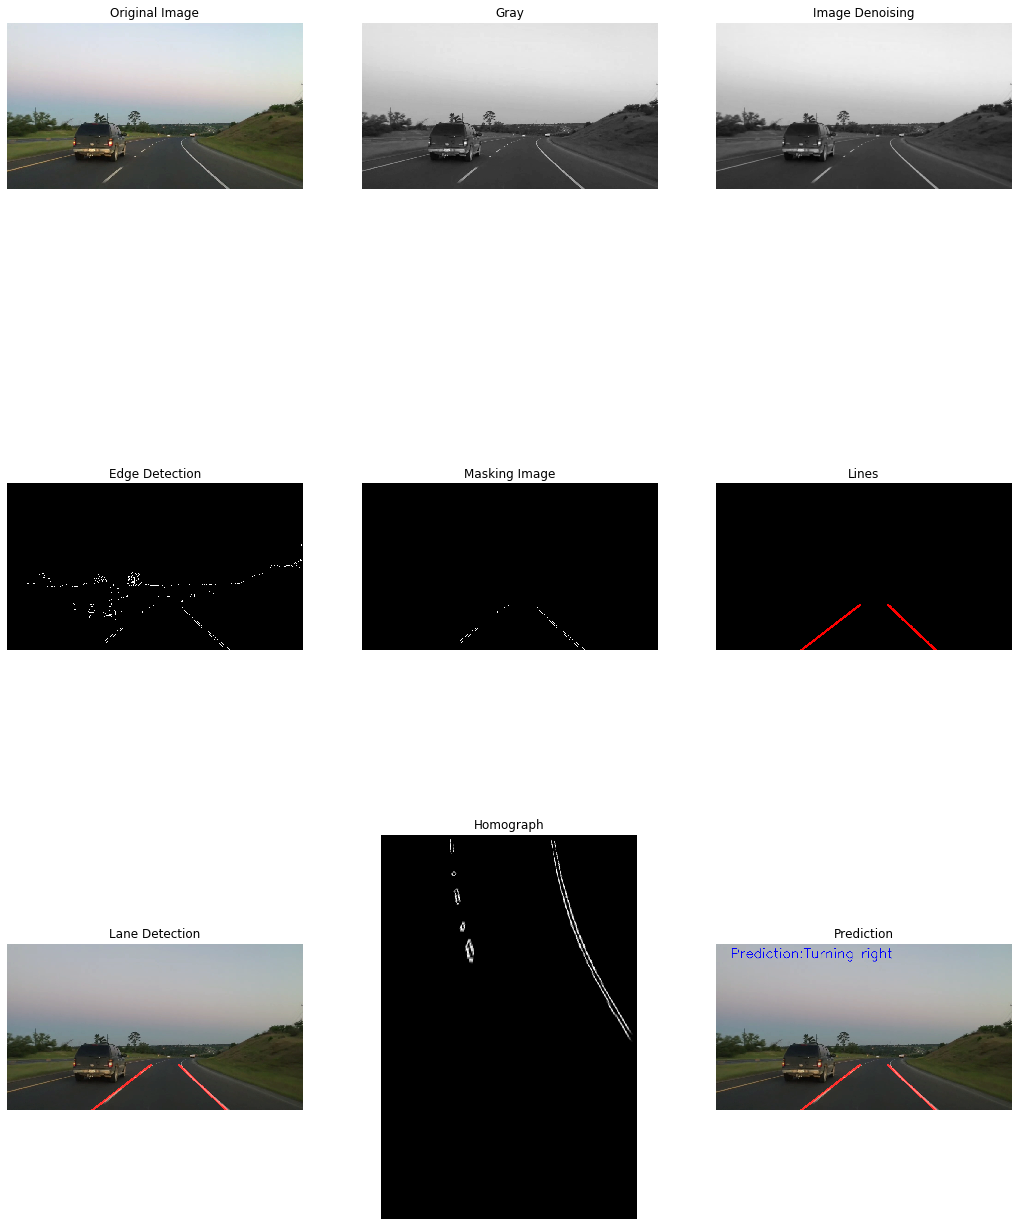

In [11]:
demo_with_image()

In [12]:
while cap.isOpened():
    
    ret, frame = cap.read()
    if ret is False:
        break
    frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
    
    timer = cv2.getTickCount()
    
    denoised_img = image_denoising(frame)
    
    edge = edge_detection(denoised_img)
    
    masked_img = image_masking(edge, vertice)
    
    lines = hough_lines_detection(masked_img)
    
    left_and_right_lines = left_and_right_lines_separation(frame.shape[0], lines)
    
    line_image = complete_line_drawing(frame,  left_and_right_lines)
    
    prediction = turn_prediction(masked_img)
    fps = cv2.getTickFrequency()/(cv2.getTickCount() - timer)
    result = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    cv2.putText(result, "FPS:"+ str(int(fps)), (50*width//1000, 50*width//1000), cv2.FONT_HERSHEY_SIMPLEX, 1.5*width/1000, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(result, "Prediction:" + prediction, (50*width//1024, 100*width//1000), cv2.FONT_HERSHEY_SIMPLEX, 1.5*width/1000, (0, 0, 255), 2, cv2.LINE_AA)
    
    out.write(result)
    cv2.imshow("Result", result)
    q = cv2.waitKey(1) & 0xff

    if q == ord('q'):
        break
cap.release()
out.release()
cv2.destroyAllWindows()

C:\Users\Bokhodir\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Bokhodir\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Bokhodir\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
C:\Users\Bokhodir\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
C:\Users\Bokhodir\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
C:\Users\Bokhodir\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
C:\Users\Bokhodir\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
C:\Users\Bokhodir\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RankWarning: Polyfit may b